## Update a wflow model: forcing

Once you have a **Wflow** model, you may want to update your model in order to use a new landuse map, change a parameter value, add sample locations, use different forcing data, create and run different scenarios etc.

With HydroMT, you can easily read your model and update one or several components of your model using the **update** function of the command line interface (CLI). Here are the steps and some examples on how to **update the model forcing**.

All lines in this notebook which starts with ! are executed from the command line. Within the notebook environment the logging messages are shown after completion. You can also copy these lines and paste them in your shell to get more feedback.

### Import packages

In this notebook, we will use some functions of HydroMT to plot the precipitation from the original and updated models. Here are the libraries to import to realize these steps.

In [1]:
import xarray as xr

In [2]:
# import hydromt
import hydromt
from hydromt.models import MODELS

In [3]:
# setup logging
from  hydromt.log import setuplog
logger = setuplog("update_model_forcing", log_level=10)

2021-04-29 09:09:42,287 - update_model_forcing - log - INFO - HydroMT version: 0.4.1.dev


### Model setup configuration

Updating landuse is an easy step with the command line but sometimes, for example with forcing, you want to update several things at the same time. This is possible by preparing a **configuration file** that includes every components and settings that you want to do during your update.

The ini-file contains the model setup configuration and determines which components are updated and in which sequence and sets optional arguments for each component. This configuration is passed to hydromt using `-i <path_to_ini_file>`.

Each header as shown between `[...]` (e.g. `[setup_precip_forcing]`) corresponds with a model component which are explained in the [docs(model_components)](https://deltares.github.io/hydromt_wflow/latest/user_guide/wflow/components.html).

Let's open the example configuration file **wflow_update_forcing.ini** from the model repository [examples folder] and have a look at the settings.

In [4]:
fn_ini = 'wflow_update_forcing.ini'
with open(fn_ini, 'r') as f:
    txt = f.read()
print(txt)

[setup_config]                  # options parsed to wflow ini file <section>.<option>
starttime = 2010-02-01T00:00:00
endtime = 2010-02-10T00:00:00
timestepsecs = 86400
input.path_forcing = inmaps-chirps-2010.nc

[setup_precip_forcing]
precip_fn       = chirps_global # source for precipitation.
precip_clim_fn  = None          # source for high resolution climatology to correct precipitation.

[setup_temp_pet_forcing]
temp_pet_fn     = era5          # source for temperature and potential evapotranspiration.
press_correction= True          # if True temperature is corrected with elevation lapse rate.
temp_correction = True          # if True pressure is corrected with elevation lapse rate.
dem_forcing_fn  = era5_orography # source of elevation grid corresponding to temp_pet_fn. Used for lapse rate correction.
pet_method      = debruin       # method to compute PET: {debruin, makkink}
skip_pet        = False         # if True, only temperature is prepared.



Here we can see that to fully update wflow forcing, we will run three components of **Wflow**:

- **setup_config**: modifies the Wflow TOML configuration file and tells hydroMT what are the start, end, timestep of the forcing data we want to prepare. Note that you can change any options in the TOML file here, including for example the name of the output forcing file with the option *input.path_forcing*.
- **setup_precip_forcing**: tells hydroMT how to prepare precipitation data including from which data source and with or without downscaling.
- **setup_temp_pet_forcing**: tells hydroMT how to prepare temperature and potential evapotranspiration data including which data source, which computation method for PET and with or without downscaling.

You can find more information on the different components and their options in the [docs(model_components)](https://deltares.github.io/hydromt_wflow/latest/user_guide/wflow/components.html).

Here we can see that we will prepare daily forcing for 10 days in February 2010 using CHIRPS for precipitation and ERA5 for temperature and potential evapotranspiration.

### hydroMT CLI update interface

Using the `hydroMT build` API, we can update one or several components of an already existing Wflow model. Let's get an overview of the available options:

In [5]:
# Print the options available from the update command
! hydromt update --help

Usage: hydromt update [OPTIONS] MODEL MODEL_ROOT

  Update a specific component of a model. Set an output directory to copy
  the edited model to a new folder, otherwise maps are overwritten.

  Example usage:
  --------------

  Update (overwrite) landuse-landcover maps in a wflow model
  hydromt update wflow /path/to/model_root -c setup_lulcmaps --opt source_name=vito

  Update reservoir maps based on default settings in a wflow model and write to new directory
  hydromt update wflow /path/to/model_root -o /path/to/model_out -c setup_reservoirs

Options:
  -o, --model-out DIRECTORY  Output model folder. Maps in MODEL_ROOT are
                             overwritten if left empty.

  -c, --components TEXT      Model components from ini file to run
  --opt TEXT                 Component specific keyword arguments, see the
                             setup_<component> method of the specific model
                             for more information about the arguments.

  -i, --config PA

### Update wflow forcing layers

In [6]:
# NOTE: copy this line (without !) to your shell for more direct feedback
! hydromt update wflow wflow_piave_subbasin -o ./wflow_piave_forcing -i wflow_update_forcing.ini -v

2021-04-29 09:09:47,853 - update - log - INFO - HydroMT version: 0.4.1.dev
2021-04-29 09:09:47,853 - update - main - INFO - Updating wflow model at /home/runner/work/hydromt_wflow/hydromt_wflow/docs/examples/examples/wflow_piave_subbasin (r).
2021-04-29 09:09:47,853 - update - main - INFO - Output dir: /home/runner/work/hydromt_wflow/hydromt_wflow/docs/examples/examples/wflow_piave_forcing
2021-04-29 09:09:47,853 - update - main - INFO - User settings:
2021-04-29 09:09:47,855 - update - cli_utils - INFO - setup_config.starttime: 2010-02-01T00:00:00
2021-04-29 09:09:47,855 - update - cli_utils - INFO - setup_config.endtime: 2010-02-10T00:00:00
2021-04-29 09:09:47,855 - update - cli_utils - INFO - setup_config.timestepsecs: 86400
2021-04-29 09:09:47,855 - update - cli_utils - INFO - setup_config.input.path_forcing: inmaps-chirps-2010.nc
2021-04-29 09:09:47,855 - update - cli_utils - INFO - setup_precip_forcing.precip_fn: chirps_global
2021-04-29 09:09:47,855 - update - cli_utils - INFO -

2021-04-29 09:09:47,923 - update - wflow - INFO - Reading model intbl files.
2021-04-29 09:09:47,924 - update - wflow - INFO - Reading model staticgeom files.


2021-04-29 09:09:48,129 - update - wflow - INFO - Read forcing from /home/runner/work/hydromt_wflow/hydromt_wflow/docs/examples/examples/wflow_piave_subbasin/inmaps.nc
2021-04-29 09:09:48,140 - update - wflow - INFO - Model read
2021-04-29 09:09:48,165 - update - data_adapter - INFO - Updating data sources from yml file /home/runner/.hydromt_data/data/v0.0.3/data_catalog.yml


2021-04-29 09:09:48,240 - update - data_adapter - INFO - DataCatalog: Getting chirps_global RasterDataset netcdf data from /home/runner/.hydromt_data/data/v0.0.3/chirps_global.nc


2021-04-29 09:09:48,386 - update - model_api - WARNING - Replacing forcing: precip
2021-04-29 09:09:48,398 - update - data_adapter - INFO - DataCatalog: Getting era5 RasterDataset netcdf data from /home/runner/.hydromt_data/data/v0.0.3/era5.nc


2021-04-29 09:09:48,500 - update - data_adapter - INFO - DataCatalog: Getting era5_orography RasterDataset netcdf data from /home/runner/.hydromt_data/data/v0.0.3/era5_orography.nc


2021-04-29 09:09:48,968 - update - model_api - WARNING - Replacing forcing: pet
2021-04-29 09:09:48,969 - update - model_api - WARNING - Replacing forcing: temp
2021-04-29 09:09:48,969 - update - wflow - INFO - Write model data to /home/runner/work/hydromt_wflow/hydromt_wflow/docs/examples/examples/wflow_piave_forcing
2021-04-29 09:09:48,969 - update - model_api - INFO - Writing model config to /home/runner/work/hydromt_wflow/hydromt_wflow/docs/examples/examples/wflow_piave_forcing/wflow_sbm.toml
2021-04-29 09:09:48,970 - update - wflow - INFO - Write staticmaps to /home/runner/work/hydromt_wflow/hydromt_wflow/docs/examples/examples/wflow_piave_forcing/staticmaps.nc


2021-04-29 09:09:49,510 - update - wflow - INFO - Writing model staticgeom to file.


2021-04-29 09:09:49,749 - update - wflow - INFO - Write forcing file


The example above means the following: run **hydromt** with:

- `update wflow`: i.e. update a wflow model
- `wflow_piave_subbasin`: original model folder
- `-o ./wflow_piave_forcing`: output updated model folder
- `-i wflow_update_forcing.ini`: setup configuration file containing the components to update and their different options
- `v`: give some extra verbosity (2 * v) to display feedback on screen. Now debug messages are provided.

### Model comparison

From the information above, you can see that the different forcing variables where updated. Compared to the original model, the temperature and potential evapotranspiration still come from the ERA5 data source but now the precipitation are using CHIRPS data.

Using the script from the [plot example](https://deltares.github.io/hydromt_wflow/latest/examples/examples/base_plots.html), we can compare the two precipitation datasets together (here *basin average* values).

In [7]:
# Import plot libraries
import matplotlib.pyplot as plt

In [8]:
# Load both models with hydromt
mod0 = hydromt.WflowModel(root='wflow_piave_subbasin', mode='r')
mod1 = hydromt.WflowModel(root='wflow_piave_forcing', mode='r')

In [9]:
# read wflow forcing; mask region outside the basin and compute the basin average
# NOTE: only very limited forcing data is available from the artifacts
ds_forcing0 = xr.merge(mod0.forcing.values()).where(mod0.staticmaps['wflow_subcatch']>0)
ds_forcing0 = ds_forcing0.mean(dim=[ds_forcing0.raster.x_dim, ds_forcing0.raster.y_dim])

ds_forcing1 = xr.merge(mod1.forcing.values()).where(mod1.staticmaps['wflow_subcatch']>0)
ds_forcing1 = ds_forcing1.mean(dim=[ds_forcing1.raster.x_dim, ds_forcing1.raster.y_dim])

Text(0, 0.5, 'precipitation\nmm.day-1')

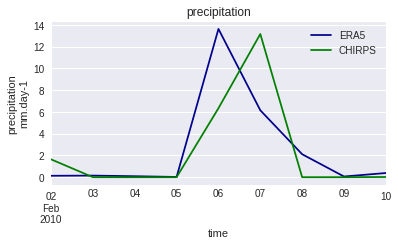

In [10]:
# plot precipitation
plt.style.use('seaborn') # set nice style
fig, axes = plt.subplots(1, 1, figsize=(6, 3))
df0 = ds_forcing0['precip'].squeeze().to_series()
df1 = ds_forcing1['precip'].squeeze().to_series()

#axes.bar(df1.index, df1.values, facecolor='green', label='CHIRPS')
#axes.bar(df0.index, df0.values, facecolor='darkblue', label='ERA5')

df0.plot.line(ax=axes, x="time", color='darkblue', label='ERA5')
df1.plot.line(ax=axes, x="time", color='green', label='CHIRPS')


axes.set_xlabel('time')
axes.legend()
axes.set_title('precipitation')
axes.set_ylabel('precipitation\nmm.day-1')